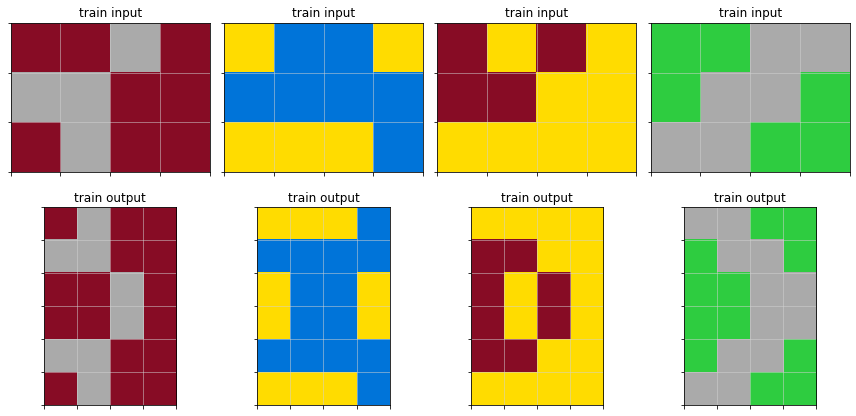

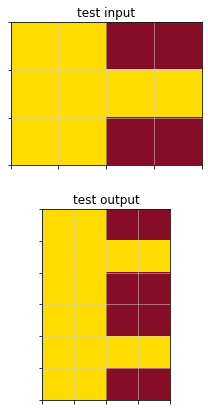

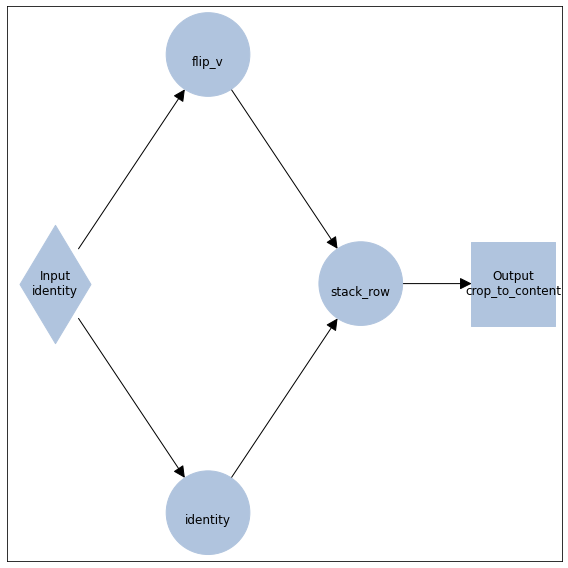

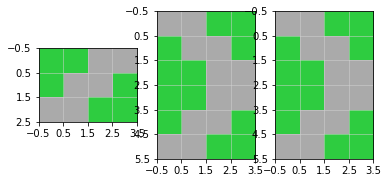

True


Exception: This is a test

In [27]:
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
import torch
from fitness import fitness_functions, product_less
from operations import all_operations

from util import feed_forward_layers, get_layer_of_node, is_solution, plot_one, required_for_output, show_image_list
from visualize import visualize_network

prob_add_connection = 0.05
prob_add_node = 0.05
prob_remove_node = 0.03
prob_remove_connection = 0.03
prob_mutate_weight = 0.03
prob_mutate_activation = 0.03
prob_reenable_connection = .025

initial_connection_prob =1.0
initial_hidden = 0


use_weights = False
max_weight = 9.0
weight_mutation = 9.0

device = 'cpu'



class Node():
    def __init__(self, activation):
        self.activation = activation
        self.sum_inputs = []
        self.current_output = []

class Connection():
    innovation = 0
    def __init__(self, from_node, to_node, weight):
        self.from_node = from_node
        self.to_node = to_node
        self.weight = weight
        self.innovation = Connection.innovation
        self.enabled = True
        Connection.innovation += 1

    def __iter__(self):
        return iter([self.from_node, self.to_node])

class Candidate():
    def __init__(self, num_inputs=1, num_outputs=1) -> None:
        self.input_nodes = []
        self.output_nodes = []
        self.connections = []
        self.hidden_nodes = []

        for _ in range(num_inputs):
            self.input_nodes.append(Node(random_activation()))
        for _ in range(num_outputs):
            self.output_nodes.append(Node(random_activation()))
        for _ in range(initial_hidden):
            self.hidden_nodes.append(Node(random_activation()))

        for inp in self.input_nodes:
            for h in self.hidden_nodes:
                if random.random() < initial_connection_prob:
                    self.connections.append(Connection(inp, h, random_weight()))
        if initial_hidden>0:
            for h in self.hidden_nodes:
                for outp in self.output_nodes:
                    if random.random() < initial_connection_prob:
                        self.connections.append(Connection(h, outp, random_weight()))
        else:
            for inp in self.input_nodes:
                for outp in self.output_nodes:
                    if random.random() < initial_connection_prob:
                        self.connections.append(Connection(inp, outp, random_weight()))
    def layers(self):
        return feed_forward_layers(self.input_nodes, self.output_nodes, self.connections)

    def enabled_connections(self):
        return [cx for cx in self.connections if cx.enabled]

    def add_node(self):
        if len(self.connections) == 0:
            self.hidden_nodes.append(Node(random_activation()))
            return
        # pick random connection to break
        cx = random.choice(self.connections)
        # create new node
        new_node = Node(random_activation())
        self.hidden_nodes.append(new_node)
        # create new connections
        new_connection_a = Connection(cx.from_node, new_node, 1.0)
        new_connection_b = Connection(new_node, cx.to_node, random_weight())
        # replace old connection with new connections
        self.connections.append(new_connection_a)
        self.connections.append(new_connection_b)
        cx.enabled = False

    def remove_node(self):
        if len(self.hidden_nodes) == 0:
            return
        random_node = random.choice(self.hidden_nodes)
        for cx in self.connections[::-1]:
            if cx.from_node == random_node or cx.to_node == random_node:
                self.connections.remove(cx)

    def add_connection(self):
        """Adds a connection to the CPPN."""
        for _ in range(20):  # try 20 times max
            [from_node, to_node] = np.random.choice(
                self.input_nodes + self.output_nodes + self.hidden_nodes, 2, replace=False)
            if from_node in self.output_nodes:
                continue
            if to_node in self.input_nodes:
                continue

            # look to see if this connection already exists
            existing_cx = None
            for cx in self.connections:
                if cx.from_node == from_node and cx.to_node == to_node:
                    existing_cx = cx

            # if it does exist and it is disabled, there is a chance to reenable
            if existing_cx is not None:
                if not existing_cx.enabled:
                    if np.random.rand() < prob_reenable_connection:
                        existing_cx.enabled = True # re-enable the connection
                break  # don't allow duplicates, don't enable more than one connection

            # else if it doesn't exist, check if it is valid
            layers = self.layers()
            from_node_layer = get_layer_of_node(from_node, layers)
            to_node_layer = get_layer_of_node(to_node, layers)
            if from_node_layer is None:
                continue
            if to_node_layer is None:
                continue
            if from_node_layer < to_node_layer:
                # valid connection, add
                new_cx = Connection(from_node, to_node, random_weight())
                self.connections.append(new_cx)
                break # found a valid connection, don't add more than one

            # else failed to find a valid connection, don't add and try again

    def remove_connection(self):
        if len(self.connections) == 0:
            return
        cx = random.choice(self.connections)
        # self.connections.remove(cx)
        cx.enabled = False

    def mutate_activations(self):
        for node in self.hidden_nodes + self.output_nodes + self.input_nodes:
            if random.random() < prob_mutate_activation:
                node.activation = random_activation()

    def mutate_weights(self):
        if not use_weights:
            return
        for cx in self.connections:
            if random.random() < prob_mutate_weight:
                cx.weight += random.gauss(0, weight_mutation)
                if cx.weight < -max_weight:
                    cx.weight = max_weight
                if cx.weight > max_weight:
                    cx.weight = max_weight

    def mutate(self):
        if random.random() < prob_add_node:
            self.add_node()
        if random.random() < prob_add_connection:
            self.add_connection()
        if random.random() < prob_remove_node:
            self.remove_node()
        if random.random() < prob_remove_connection:
            self.remove_connection()
        self.mutate_weights()
        self.mutate_activations()

    def reset_nodes(self):
        """Reset all nodes to their initial state."""
        for node in self.hidden_nodes + self.output_nodes + self.input_nodes:
            node.current_output = []

    def evaluate(self, input_sample):
        """Evaluate the network to get data in parallel"""
        self.reset_nodes()
        layers = self.layers()
        for layer_index, layer in enumerate(layers):
            # iterate over layers
            for _, node in enumerate(layer):
                # iterate over nodes in layer
                # find incoming connections
                incoming = list(filter(lambda x, n=node: x.to_node == n, self.connections))
                # initialize the sum_inputs for this node
                if layer_index == 0:
                    node.current_output = [input_sample]
                else:
                    node.current_output = [] # reinitialize the node's current_output

                for cx in incoming:
                    from_layer_index = get_layer_of_node(cx.from_node, layers)
                    to_layer_index = get_layer_of_node(cx.to_node, layers)
                    # ignore recurrent connections
                    if from_layer_index == to_layer_index or\
                        from_layer_index == to_layer_index:
                            print("found recurrent connection")
                            continue

                    # a list of pixmaps
                    inputs = cx.from_node.current_output
                    assert isinstance(inputs, list)

                    for i in range(len(inputs)):
                        if use_weights:
                            inputs[i] = torch.mul(inputs[i].type(torch.float32), cx.weight)

                        if i >= len(node.current_output):
                            node.current_output.append(inputs[i])
                        else:
                            node.current_output.append(inputs[i])


                # normalize      
                for output_index, _ in enumerate(node.current_output):
                    node.current_output[output_index] = torch.nan_to_num(node.current_output[output_index], 0)
                    if node.current_output[output_index].numel() == 0:
                        continue
                    if use_weights:
                        node.current_output[output_index] = node.current_output[output_index].type(torch.float32)
                        max_value = torch.max(node.current_output[output_index])
                        min_value = torch.min(node.current_output[output_index])
                        node.current_output[output_index] = (node.current_output[output_index] - min_value) / (max_value - min_value)
                        node.current_output[output_index] *= 9.0
                        node.current_output[output_index] = torch.round(node.current_output[output_index])
                        
                    node.current_output[output_index] = node.current_output[output_index].type(torch.int8)
                
                node.current_output = [torch.nan_to_num(x, 0) for x in node.current_output]
                node.current_output = node.activation(node.current_output)  # apply activation
                
        # collect outputs from the last layer
        outputs = [o.current_output for o in self.output_nodes]
        # outputs = torch.tensor([node.current_output for node in output_nodes])
        return outputs # a list of list of pixmaps

    def evaluate_fitness(self, task):
        score = torch.zeros((len(fitness_functions)))
        for sample in task:
            i = torch.tensor(sample['input']).to(device)
            o = torch.tensor(sample['output']).to(device)
            i = i.type(torch.FloatTensor)
            o = o.type(torch.FloatTensor)

            # For each fitness function
            for index, fitness_function in enumerate(fitness_functions):
                outputs = self.evaluate(copy.deepcopy(i))
                if outputs == []: # Penalize no prediction!
                    score[index] += 500
                else: # Take only the score of the first output
                    images = outputs[0] # take first output neuron, list of pixmaps
                    images = [img for img in images if img.shape[0] > 0 and img.shape[1] > 0]
                    if len(images) == 0:
                        score[index] += 500
                        continue
                    
                    guesses = images
                    guesses = guesses[:3] # only take the first 3 guesses
                    score[index] = min([fitness_function(img, o) for img in guesses])

        return tuple(score)

def random_weight():
    return random.uniform(-max_weight,max_weight)
def random_activation():
    return random.choice(all_operations)


def pad_to_same(x, y):
    # pad the output to match the input
    if x.shape[-2] < y.shape[-2]:
        x = torch.nn.functional.pad(x, (0,0, y.shape[-2] - x.shape[-2], 0), value=-1)
    elif x.shape[-2] > y.shape[-2]:
        y = torch.nn.functional.pad(y, (0,0, x.shape[-2] - y.shape[-2], 0), value=-1)
    if x.shape[-1] < y.shape[-1]:
        x = torch.nn.functional.pad(x, (0, y.shape[-1] - x.shape[-1], 0, 0), value=-1)
    elif x.shape[-1] > y.shape[-1]:
        y = torch.nn.functional.pad(y, (0, x.shape[-1] - y.shape[-1], 0, 0), value=-1)
    return x, y


if __name__ == "__main__":
    from util import plot_task
    import os
    import json
    from tqdm.notebook import trange
    from operations import *
    TRAIN_PATH = './ARC/data/training'
    training_tasks = sorted(os.listdir(TRAIN_PATH))
    

    # easy tasks: 13, 30, 115

    task = training_tasks[115]
    task_path = os.path.join(TRAIN_PATH, task)
    with open(task_path, 'r') as f:
        task_ = json.load(f)
    task = task_    
    plot_task(task)
    task = task_['train']
    task = task[-1]

    test_candidate = Candidate()
    test_candidate.input_nodes[0].activation = identity
    test_candidate.hidden_nodes.append(Node(activation=flip_v))
    test_candidate.hidden_nodes.append(Node(activation=identity))
    test_candidate.hidden_nodes.append(Node(activation=stack_row))

    test_candidate.output_nodes[0].activation = crop_to_content
    test_candidate.connections = []
    test_candidate.connections.append(Connection(test_candidate.input_nodes[0], test_candidate.hidden_nodes[0], weight=1))
    test_candidate.connections.append(Connection(test_candidate.input_nodes[0], test_candidate.hidden_nodes[1], weight=1))
    test_candidate.connections.append(Connection(test_candidate.hidden_nodes[0], test_candidate.hidden_nodes[2], weight=1))
    test_candidate.connections.append(Connection(test_candidate.hidden_nodes[1], test_candidate.hidden_nodes[2], weight=1))
    test_candidate.connections.append(Connection(test_candidate.hidden_nodes[2], test_candidate.output_nodes[0], weight=1))
    
    visualize_network(test_candidate, visualize_disabled=True)
    i = torch.tensor(task['input']).to(device)
    o = torch.tensor(task['output']).to(device)
    i = i.type(torch.FloatTensor).clone()
    o = o.type(torch.FloatTensor).clone()


    output = test_candidate.evaluate(i)
    output = output[0]
    show_image_list([i, o] + output)
    sol = is_solution(test_candidate, task_['train'])
    print(sol)
    raise Exception("This is a test")

    
    
    # tasks = training_tasks[:5]
    # random.shuffle(training_tasks)
    tasks = [30]
    # hillclimber
    for task_id in tasks:
        task = training_tasks[task_id]
        task_path = os.path.join(TRAIN_PATH, task)
        with open(task_path, 'r') as f:
            task_ = json.load(f)
        task = task_['train']
        parent = Candidate()
        parent_score, child_score = np.inf, np.inf
        scores =[]
        p = trange(2000)
        for i in p:
            parent_score = parent.evaluate_fitness(task)
            child = copy.deepcopy(parent)
            child.mutate()
            child_score = child.evaluate_fitness(task)
            if product_less(child_score, parent_score):
                parent = child
                parent_score = child_score
                if is_solution(parent, task):
                    print("solution found")
                    p.close()
                    break
            # if product_less(child_score, parent_score):
                # print(parent_score, child_score)
            # p.set_description(f"{parent_score} {child_score}")
            p.set_postfix_str(f"{np.mean(list(parent_score))}")
            scores.append(np.mean(list(parent_score)))
            if i % 100 == 0:
                visualize_network(parent)
        # plt.plot(scores)
        print(tuple(parent_score))